# Detectron2: Train on a custom dataset
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Object-Detection-and-Image-Segmentation-with-Detectron2/blob/master/Detectron2_train_on_a_custom_dataset.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Object-Detection-and-Image-Segmentation-with-Detectron2/blob/master/Detectron2_train_on_a_custom_dataset.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [1]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.1MB 25.8MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 276kB 6.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=7ac95aebeb1d79f3481cdc00ef00a38a86767f80ebfea133b63d80c47afdce17
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [2]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 804kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200506-cp36-none-any.whl size=40569 sha256=cebb70e7214294c01f6b925c04b7944b2896896a8bb314ea81e275b74cfa8ca9
  Stored in directory: /root/.cache/pip/wheels/3f/db/ab/307827ba85b8cc1d288f096909499ecdbcac90db4edaa088fe
Successfully built fvcore


## Train on a custom dataset

In [0]:
# import some common libraries
import itertools
import json
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode




setup_logger()

Here we download our dataset from github.

In [65]:
!wget https://github.com/j0rd1smit/fish_dataset/archive/fish_dataset.zip
!unzip fish_dataset.zip > /dev/null

--2020-05-06 18:31:00--  https://github.com/j0rd1smit/fish_dataset/archive/fish_dataset.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/j0rd1smit/fish_dataset/zip/fish_dataset [following]
--2020-05-06 18:31:00--  https://codeload.github.com/j0rd1smit/fish_dataset/zip/fish_dataset
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘fish_dataset.zip’

fish_dataset.zip        [    <=>             ]   5.23M  7.05MB/s    in 0.7s    

2020-05-06 18:31:02 (7.05 MB/s) - ‘fish_dataset.zip’ saved [5482917]



In order to use a dataset with Detectron2 we need to register it. For more information check out the [official documentation](https://detectron2.readthedocs.io/tutorials/datasets.html#register-a-dataset).

In [0]:
# here we change the annotations into the format that is need for elector
def get_fish_dicts(img_dir):
    json_file = os.path.join(img_dir, "annotations.json")
    print(json_file)
    with open(json_file) as f:
        data = json.load(f)

    dataset_dicts = []
    for k, image_data in data.items():
        record = {}

        record["file_name"] = os.path.join(img_dir, image_data["filename"])

        h, w = cv2.imread(record["file_name"]).shape[:2]
        record["height"] = h
        record["width"] = w

        annotations = []

        for region in image_data["regions"]:
            shape_attributes = region["shape_attributes"]
            px = shape_attributes["all_points_x"]
            py = shape_attributes["all_points_y"]

            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = list(itertools.chain.from_iterable(poly))

            annotation = {
                "bbox": [min(px), min(py), max(px), max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,  # There is only 1 catagory
                "iscrowd": 0
            }
            annotations.append(annotation)

        record["annotations"] = annotations

        dataset_dicts.append(record)
    return dataset_dicts

# This need to be able to rerun the cell in a notebook
DatasetCatalog.clear()

# Register both datasets.
for d in ["train", "test"]:
    DatasetCatalog.register("fish_dataset-fish_dataset_" + d, lambda: get_fish_dicts("fish_dataset-fish_dataset/" + d))
    MetadataCatalog.get("fish_dataset-fish_dataset_" + d).set(thing_classes=["balloon"])
fish_metadata = MetadataCatalog.get("fish_dataset-fish_dataset_train")

Here we display some of the images in the dataset:

In [0]:
dataset_dicts = get_fish_dicts("fish_dataset-fish_dataset/train")

for d in dataset_dicts[:3]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fish_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Here we fine tune a model from the zoo to our dataset.

In [0]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fish_dataset-fish_dataset_train",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 5   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (zebra_fish)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[05/06 19:08:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Here we create a predictor using the learned weights.

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("fish_dataset-fish_dataset_test", )
predictor = DefaultPredictor(cfg)

Here we display the prediction for the unseen testset.

fish_dataset-fish_dataset/test/annotations.json
{'instances': Instances(num_instances=1, image_height=1024, image_width=1024, fields=[pred_boxes: Boxes(tensor([[159.5513, 470.5213, 448.5836, 609.7758]], device='cuda:0')), scores: tensor([0.7289], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


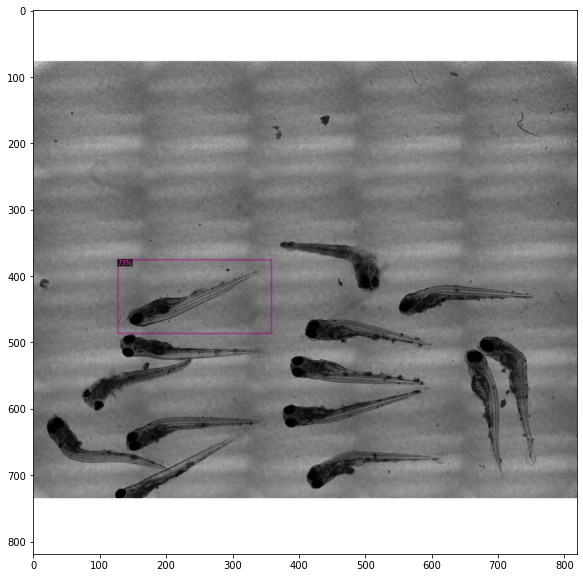

{'instances': Instances(num_instances=3, image_height=1024, image_width=1024, fields=[pred_boxes: Boxes(tensor([[ 75.2585, 517.0569, 292.6885, 641.9604],
        [725.0015, 233.0296, 944.3265, 357.9669],
        [546.8432, 158.9724, 772.9406, 304.6686]], device='cuda:0')), scores: tensor([0.7348, 0.7314, 0.7274], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0')])}


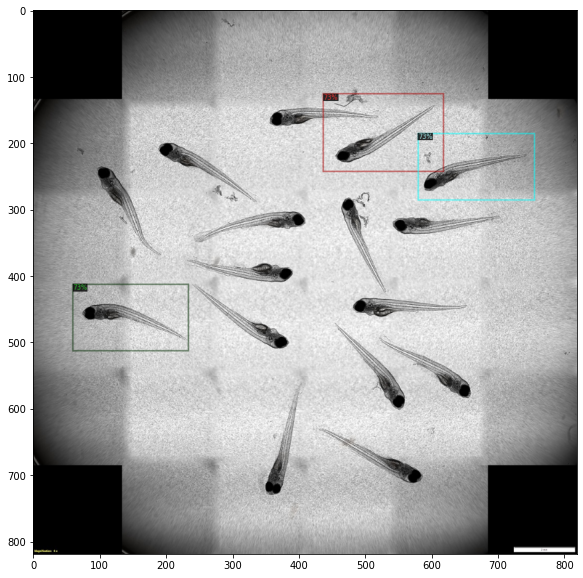

{'instances': Instances(num_instances=1, image_height=1024, image_width=1024, fields=[pred_boxes: Boxes(tensor([[753.0266,  88.7164, 859.7300, 306.8491]], device='cuda:0')), scores: tensor([0.7154], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


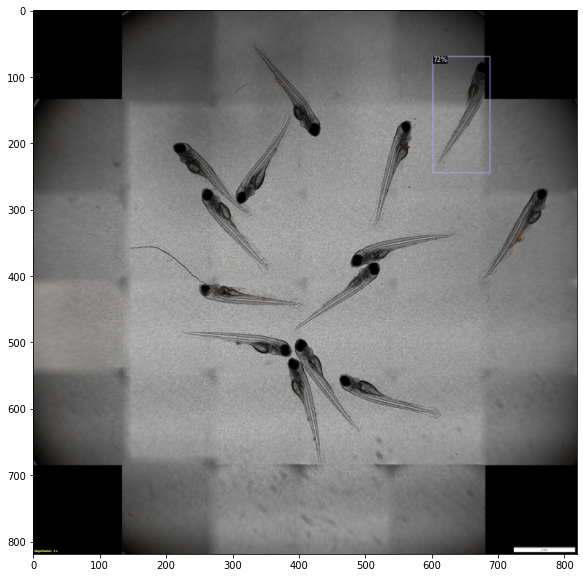

{'instances': Instances(num_instances=0, image_height=1024, image_width=1024, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


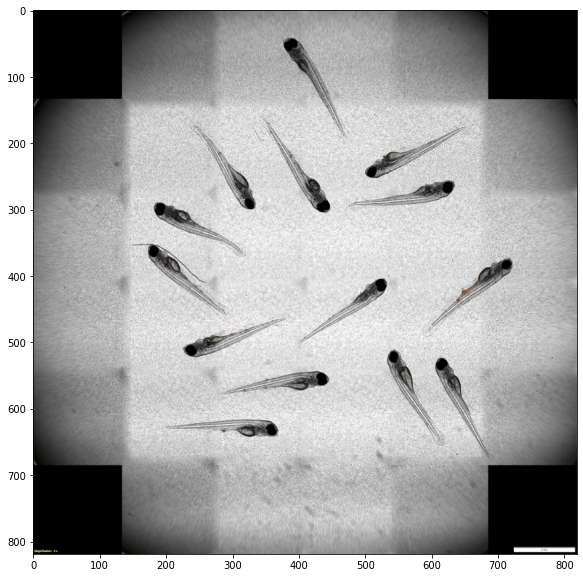

In [118]:
from detectron2.utils.visualizer import ColorMode
data = get_fish_dicts("fish_dataset-fish_dataset/test")

for d in data:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    
    #v = Visualizer(im[:, :, ::-1], metadata=fish_metadata, scale=0.8)
    #v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    v = Visualizer(im[:, :, ::-1],
                   metadata=fish_metadata, 
                   scale=0.8, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))


    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()



Here we display the target bounding boxes for the testset.

fish_dataset-fish_dataset/test/annotations.json


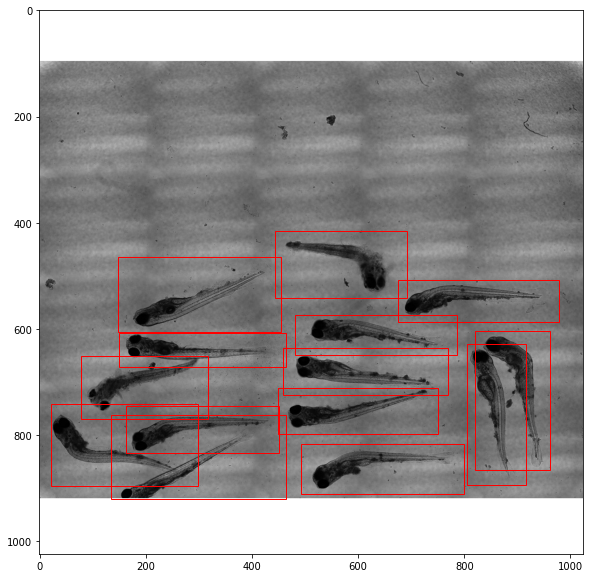

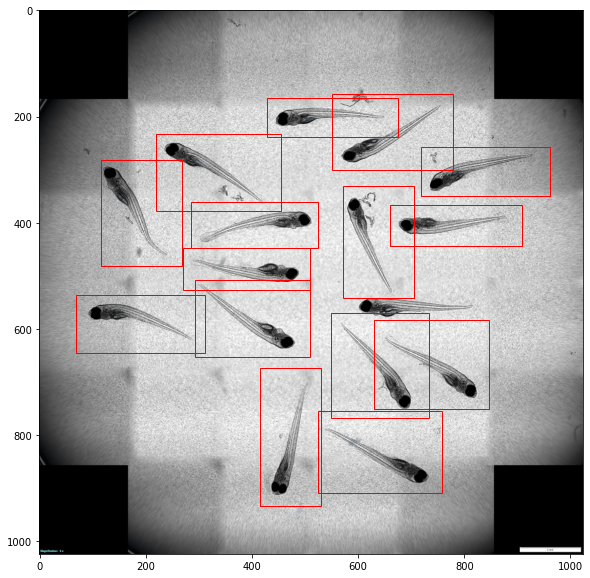

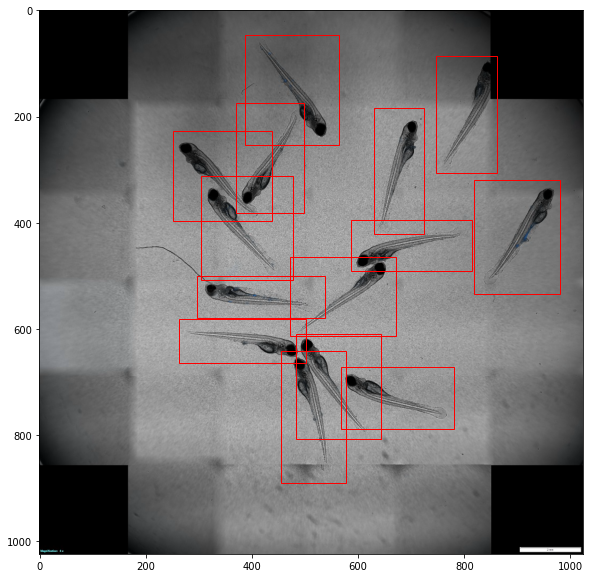

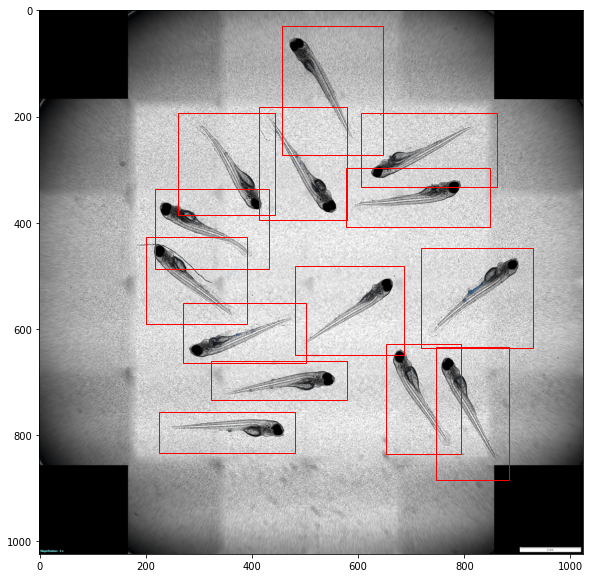

In [100]:
from matplotlib.patches import Rectangle

data = get_fish_dicts("fish_dataset-fish_dataset/test")

for d in data:    
    img = cv2.imread(d["file_name"])


    plt.figure(figsize = (14, 10))
    plt.imshow(img)

    for ann in d["annotations"]:
      px_min, py_min, px_max, py_max = ann["bbox"]
      plt.gca().add_patch(Rectangle((px_min, py_min), px_max - px_min,py_max - py_min, linewidth=1, edgecolor='r', facecolor='none'))


    plt.show()